<a href="https://colab.research.google.com/github/nehasharmn/Hybrid_CNN_Transformer_CHBMIT/blob/main/CNN__Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne braindecode torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 130.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/chbmit_data"
print("Using:", DATA_ROOT)


Mounted at /content/drive
Using: /content/drive/MyDrive/chbmit_data


In [3]:
import os

required = [
    "RECORDS-WITH-SEIZURES",
    "chb01-summary.txt",
    "chb02-summary.txt",
    "chb03-summary.txt",
    "chb13-summary.txt",
    "chb20-summary.txt"
]

print("Checking summary files...")
for f in required:
    path = os.path.join(DATA_ROOT, f)
    print(f"{f}:", "OK" if os.path.exists(path) else "MISSING")


Checking summary files...
RECORDS-WITH-SEIZURES: OK
chb01-summary.txt: OK
chb02-summary.txt: OK
chb03-summary.txt: OK
chb13-summary.txt: OK
chb20-summary.txt: OK


In [4]:
def parse_summary_file(path):
    events = {}
    current_file = None
    start = None

    with open(path, "r") as f:
        for line in f:
            line = line.strip()

            if line.startswith("File Name:"):
                current_file = line.split(":")[1].strip().lower()
                events[current_file] = []
                continue

            if "Start Time" in line and "Seizure" in line:
                start = float(
                    line.split(":")[1].replace("seconds", "").strip()
                )
                continue

            if "End Time" in line and "Seizure" in line:
                end = float(
                    line.split(":")[1].replace("seconds", "").strip()
                )
                events[current_file].append((start, end))
                continue

    return events

SUMMARY = {
    "chb01": parse_summary_file(os.path.join(DATA_ROOT, "chb01-summary.txt")),
    "chb02": parse_summary_file(os.path.join(DATA_ROOT, "chb02-summary.txt")),
    "chb03": parse_summary_file(os.path.join(DATA_ROOT, "chb03-summary.txt")),
    "chb13": parse_summary_file(os.path.join(DATA_ROOT, "chb13-summary.txt")),
    "chb20": parse_summary_file(os.path.join(DATA_ROOT, "chb20-summary.txt")),
}

def load_seizure_intervals(patient, edf_filename):
    return SUMMARY.get(patient, {}).get(edf_filename.lower(), [])

In [5]:
import mne
import numpy as np

CHB_CHANNELS = [
    "FP1-F7","F7-T7","T7-P7","P7-O1",
    "FP1-F3","F3-C3","C3-P3","P3-O1",
    "FP2-F4","F4-C4","C4-P4","P4-O2",
    "FP2-F8","F8-T8","T8-P8","P8-O2",
    "FZ-CZ","CZ-PZ","P7-T7",
    "T7-FT9","FT9-FT10","FT10-T8","T8-P8"
]

def load_raw_fixed_channels(edf_path):
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

    current = [ch.lower() for ch in raw.ch_names]

    data_list = []
    for ch in CHB_CHANNELS:
        name = ch.lower()
        if name in current:
            idx = current.index(name)
            data_list.append(raw.get_data(picks=[idx]))
        else:
            data_list.append(np.zeros((1, raw.n_times)))

    return np.vstack(data_list), raw.info["sfreq"]


In [6]:
def extract_windows_balanced(
    edf_path, patient,
    window_size=4.0,
    stride=0.5,
    non_seizure_fraction=0.01
):
    data, sfreq = load_raw_fixed_channels(edf_path)
    data = (data - data.mean(axis=1, keepdims=True)) / (data.std(axis=1, keepdims=True) + 1e-6)
    n_samples = data.shape[1]

    intervals = load_seizure_intervals(patient, os.path.basename(edf_path))
    seizure_segments = [(int(s * sfreq), int(e * sfreq)) for s, e in intervals]

    win_len = int(window_size * sfreq)
    step = int(stride * sfreq)

    seizure_X, seizure_y = [], []
    non_X, non_y = [], []

    for start in range(0, n_samples - win_len, step):
        end = start + win_len
        seg = data[:, start:end]

        is_seizure = any(not (end < s_start or start > s_end)
                         for s_start, s_end in seizure_segments)

        if is_seizure:
            seizure_X.append(seg)
            seizure_y.append(1)
        else:
            non_X.append(seg)
            non_y.append(0)

    if len(non_X) > 0:
        keep = int(len(non_X) * non_seizure_fraction)
        idx = np.random.choice(len(non_X), keep, replace=False)
        non_X = np.array(non_X)[idx]
        non_y = np.array(non_y)[idx]
    else:
        non_X = np.array([])
        non_y = np.array([])

    if len(seizure_X) > 0:
        seizure_X = np.array(seizure_X)
        seizure_y = np.array(seizure_y)

        X = np.concatenate([seizure_X, non_X], axis=0)
        y = np.concatenate([seizure_y, non_y], axis=0)
    else:
        X = non_X
        y = non_y

    return X, y


In [9]:
train_patients = {"chb01", "chb02", "chb03", "chb13"}
val_patient = "chb20"

train_X, train_y = [], []
val_X, val_y = [], []

for edf in sorted(os.listdir(DATA_ROOT)):
    if not edf.endswith(".edf"):
        continue

    patient = edf[:5].lower()
    path = os.path.join(DATA_ROOT, edf)

    X, y = extract_windows_balanced(path, patient, window_size= 2)

    if patient in train_patients:
        train_X.append(X)
        train_y.append(y)
    elif patient == val_patient:
        val_X.append(X)
        val_y.append(y)

train_X = np.vstack(train_X)
train_y = np.hstack(train_y)

val_X = np.vstack(val_X)
val_y = np.hstack(val_y)

print("Train:", train_X.shape, np.unique(train_y, return_counts=True))
print("Val:", val_X.shape, np.unique(val_y, return_counts=True))


/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8

Train: (9041, 23, 512) (array([0, 1]), array([5794, 3247]))
Val: (1020, 23, 512) (array([0, 1]), array([392, 628]))


In [ ]:
import numpy as np

total = len(val_y)
seizures = np.sum(val_y == 1)
non_seizures = np.sum(val_y == 0)

print("Total val windows:", total)
print("Seizure windows:", seizures)
print("Non-seizure windows:", non_seizures)
print("Percent seizure: {:.4f}%".format(100 * seizures / total))


In [ ]:
import numpy as np

total = len(train_y)
seizures = np.sum(train_y == 1)
non_seizures = np.sum(train_y == 0)

print("Total train windows:", total)
print("Seizure windows:", seizures)
print("Non-seizure windows:", non_seizures)
print("Percent seizure: {:.4f}%".format(100 * seizures / total))


Using device: cuda
Train data shape: torch.Size([8985, 23, 256]), labels shape: torch.Size([8985])
Val data shape: torch.Size([1004, 23, 256]), labels shape: torch.Size([1004])
Train class distribution: (array([0, 1]), array([5796, 3189]))
Val class distribution: (array([0, 1]), array([392, 612]))

Class distribution: {np.int64(0): np.int64(5796), np.int64(1): np.int64(3189)}
Class weights: [negative=1.0000, positive=1.8175]
Positive class weighted 1.82x more than negative


--- Epoch 1/20 ---
Train Loss: 0.2987, Train Acc: 0.8830
Val Loss: 1.1446
Val Acc: 0.6902, Prec: 0.9493, Rec: 0.5196, F1: 0.6716, AUC: 0.7403
✓ New best F1: 0.6716

--- Epoch 2/20 ---
Train Loss: 0.1480, Train Acc: 0.9517
Val Loss: 1.5154
Val Acc: 0.6743, Prec: 0.8760, Rec: 0.5425, F1: 0.6700, AUC: 0.6947

--- Epoch 3/20 ---
Train Loss: 0.1098, Train Acc: 0.9630
Val Loss: 2.1233
Val Acc: 0.6365, Prec: 0.9524, Rec: 0.4248, F1: 0.5876, AUC: 0.6566

--- Epoch 4/20 ---
Train Loss: 0.0824, Train Acc: 0.9717
Val Loss: 2.

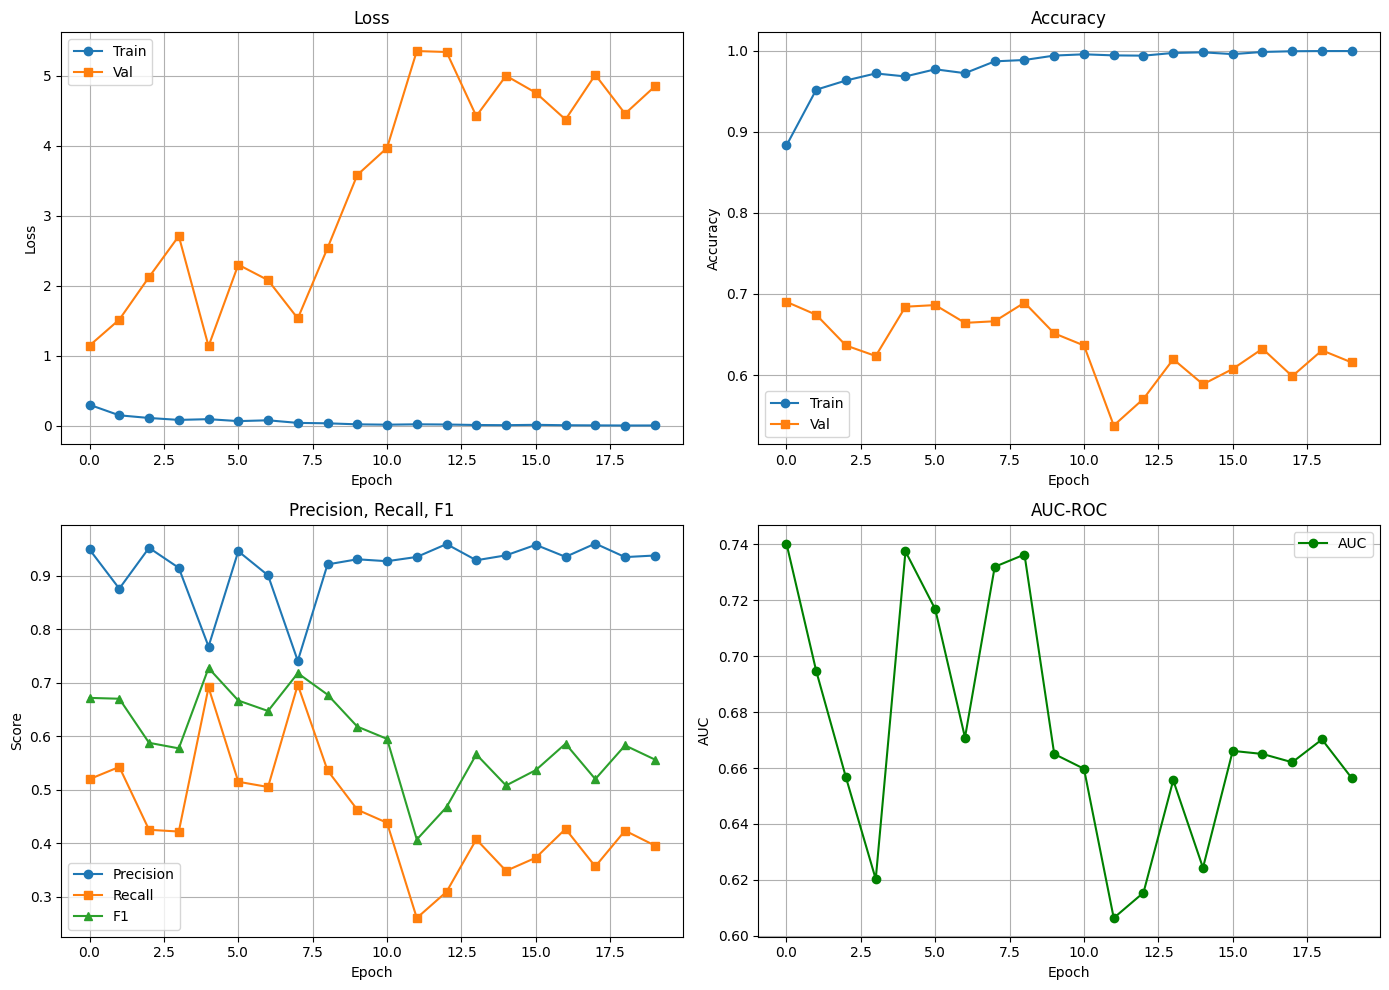


✓ Training complete!
✓ Model saved as 'seizure_model.pth'


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import time

class EEGConvNet(nn.Module):
    """Lightweight CNN for seizure detection."""
    def __init__(self, num_channels=23, num_classes=2, dropout=0.5, input_sequence_length=512):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=10, stride=2, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(64, 128, kernel_size=8, stride=2, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(128, 256, kernel_size=6, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )


        with torch.no_grad():
            dummy_input = torch.zeros(1, num_channels, input_sequence_length)
            flat_output = self.conv_layers(dummy_input).view(1, -1)
            self.flat_size = flat_output.size(1)

        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(self.flat_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def train_epoch(model, loader, opt, criterion, device):
    model.train()
    loss_sum = 0.0
    correct = 0
    total = 0

    for batch_idx, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch {batch_idx + 1}: loss={loss.item():.4f}")

    epoch_loss = loss_sum / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):

    model.eval()
    loss_sum = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = criterion(logits, y)

            loss_sum += loss.item() * y.size(0)

            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    epoch_loss = loss_sum / len(all_labels)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    return {
        'loss': epoch_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }


def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, device='cuda', train_y=None):

    if train_y is not None:
        if isinstance(train_y, torch.Tensor):
            train_y_np = train_y.cpu().numpy()
        else:
            train_y_np = train_y

        unique, counts = np.unique(train_y_np, return_counts=True)
        class_counts = dict(zip(unique, counts))

        total = len(train_y_np)
        weights = torch.tensor([total / class_counts[i] if i in class_counts else 1.0
                               for i in range(2)], device=device, dtype=torch.float32)
        weights = weights / weights[0]

        print(f"\n{'='*60}")
        print(f"Class distribution: {class_counts}")
        print(f"Class weights: [negative={weights[0]:.4f}, positive={weights[1]:.4f}]")
        print(f"Positive class weighted {weights[1]:.2f}x more than negative")
        print(f"{'='*60}\n")

        criterion = nn.CrossEntropyLoss(weight=weights)
    else:
        print("WARNING: train_y not provided, using unweighted loss")
        criterion = nn.CrossEntropyLoss()

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='max', factor=0.5, patience=3
    )

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'val_auc': []
    }

    best_val_f1 = 0
    best_model_state = None

    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch+1}/{epochs} ---")

        train_loss, train_acc = train_epoch(model, train_loader, opt, criterion, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        val_metrics = validate(model, val_loader, criterion, device)
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val Acc: {val_metrics['accuracy']:.4f}, Prec: {val_metrics['precision']:.4f}, "
              f"Rec: {val_metrics['recall']:.4f}, F1: {val_metrics['f1']:.4f}, AUC: {val_metrics['auc']:.4f}")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_auc'].append(val_metrics['auc'])

        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_model_state = model.state_dict().copy()
            print(f"✓ New best F1: {best_val_f1:.4f}")

        scheduler.step(val_metrics['f1'])

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nRestored best model with F1: {best_val_f1:.4f}")

    return model, history


def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].plot(history['train_loss'], label='Train', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val', marker='s')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    axes[0, 0].set_title('Loss')

    axes[0, 1].plot(history['train_acc'], label='Train', marker='o')
    axes[0, 1].plot(history['val_acc'], label='Val', marker='s')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    axes[0, 1].set_title('Accuracy')

    axes[1, 0].plot(history['val_precision'], label='Precision', marker='o')
    axes[1, 0].plot(history['val_recall'], label='Recall', marker='s')
    axes[1, 0].plot(history['val_f1'], label='F1', marker='^')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    axes[1, 0].set_title('Precision, Recall, F1')

    axes[1, 1].plot(history['val_auc'], label='AUC', marker='o', color='green')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    axes[1, 1].set_title('AUC-ROC')

    plt.tight_layout()
    return fig




if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")


    train_X_torch = torch.from_numpy(train_X).float() if isinstance(train_X, np.ndarray) else train_X
    train_y_torch = torch.from_numpy(train_y).long() if isinstance(train_y, np.ndarray) else train_y
    val_X_torch = torch.from_numpy(val_X).float() if isinstance(val_X, np.ndarray) else val_X
    val_y_torch = torch.from_numpy(val_y).long() if isinstance(val_y, np.ndarray) else val_y

    print(f"Train data shape: {train_X_torch.shape}, labels shape: {train_y_torch.shape}")
    print(f"Val data shape: {val_X_torch.shape}, labels shape: {val_y_torch.shape}")
    print(f"Train class distribution: {np.unique(train_y_torch.cpu().numpy(), return_counts=True)}")
    print(f"Val class distribution: {np.unique(val_y_torch.cpu().numpy(), return_counts=True)}")

    train_dataset = TensorDataset(train_X_torch, train_y_torch)
    val_dataset = TensorDataset(val_X_torch, val_y_torch)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

    model = EEGConvNet(num_channels=23, num_classes=2, dropout=0.5)
    model = model.to(device)

    model, history = train_model(
        model, train_loader, val_loader,
        epochs=20, lr=1e-3, device=device,
        train_y=train_y_torch
    )


    fig = plot_training_history(history)
    plt.savefig('seizure_training_history.png', dpi=100, bbox_inches='tight')
    plt.show()

    torch.save(model.state_dict(), 'seizure_model.pth')
    print("\n✓ Training complete!")
    print("✓ Model saved as 'seizure_model.pth'")

In [15]:
def evaluate_seizure_detection(model, loader):
    model.eval()
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            logits = model(X)
            probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = (probs > 0.3).astype(int)
            preds_all.extend(preds)
            labels_all.extend(y.cpu().numpy())

    preds_all = np.array(preds_all)
    labels_all = np.array(labels_all)

    tp = np.sum((preds_all == 1) & (labels_all == 1))
    fp = np.sum((preds_all == 1) & (labels_all == 0))
    fn = np.sum((preds_all == 0) & (labels_all == 1))

    sensitivity = tp / (tp + fn + 1e-8)
    precision   = tp / (tp + fp + 1e-8)

    print("TP:", tp)
    print("FP:", fp)
    print("FN:", fn)
    print("Sensitivity (Recall):", sensitivity)
    print("Precision:", precision)

In [30]:
print("\n=== SEIZURE DETECTION METRICS ===")
evaluate_seizure_detection(model, val_loader)


=== SEIZURE DETECTION METRICS ===
TP: 219
FP: 13
FN: 409
Sensitivity (Recall): 0.34872611464412856
Precision: 0.9439655172006911


In [10]:
def benchmark_model(model, val_loader):
    import time
    model.eval()

    # --- Latency ---
    latencies = []
    with torch.no_grad():
        for X, _ in val_loader:
            X = X.to(device)
            start = time.time()
            _ = model(X)
            end = time.time()
            latencies.append(end - start)
    avg_latency = np.mean(latencies)

    # --- Throughput ---
    throughput = len(val_loader.dataset) / sum(latencies)

    # --- Accuracy ---
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = logits.argmax(dim=1)  # Fixed: Use argmax to get the predicted class index
            correct += (preds == y).sum().item()
            total += y.size(0)
    accuracy = correct / total

    return {
        "latency": avg_latency,
        "throughput": throughput,
        "accuracy": accuracy
    }

In [16]:
window_sizes = [1, 2, 4]
results = {}

for win in window_sizes:

    print(f"Training CNN baseline with window size = {win} sec")

    train_X, train_y = [], []
    val_X, val_y = [], []

    sfreq = 256
    current_sequence_length = int(win * sfreq)

    for edf in sorted(os.listdir(DATA_ROOT)):
        if not edf.endswith(".edf"):
            continue

        patient = edf[:5].lower()
        path = os.path.join(DATA_ROOT, edf)

        X, y = extract_windows_balanced(path, patient, window_size=win)

        if patient in train_patients:
            train_X.append(X)
            train_y.append(y)
        elif patient == val_patient:
            val_X.append(X)
            val_y.append(y)

    train_X = np.vstack(train_X)
    train_y = np.hstack(train_y)
    val_X   = np.vstack(val_X)
    val_y   = np.hstack(val_y)

    train_X_torch = torch.from_numpy(train_X).float()
    train_y_torch = torch.from_numpy(train_y).long()
    val_X_torch = torch.from_numpy(val_X).float()
    val_y_torch = torch.from_numpy(val_y).long()

    train_loader = DataLoader(TensorDataset(train_X_torch, train_y_torch), batch_size=64, shuffle=True)
    val_loader   = DataLoader(TensorDataset(val_X_torch, val_y_torch), batch_size=64, shuffle=False)

    model = EEGConvNet(input_sequence_length=current_sequence_length).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    unique, counts = np.unique(train_y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    total = len(train_y)
    weights = torch.tensor([total / class_counts[i] if i in class_counts else 1.0
                           for i in range(2)], device=device, dtype=torch.float32)
    weights = weights / weights[0]
    criterion = nn.CrossEntropyLoss(weight=weights)

    print(f"\nClass distribution: {class_counts}")
    print(f"Class weights: [negative={weights[0]:.4f}, positive={weights[1]:.4f}]")
    print(f"Positive class weighted {weights[1]:.2f}x more than negative\n")

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [],
        'val_f1': [], 'val_auc': []
    }
    best_val_f1 = 0
    best_model_state = None

    for epoch in range(10):
        print(f"--- Epoch {epoch+1}/10 ---")
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_metrics = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_auc'].append(val_metrics['auc'])

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, Prec: {val_metrics['precision']:.4f}, Rec: {val_metrics['recall']:.4f}, F1: {val_metrics['f1']:.4f}, AUC: {val_metrics['auc']:.4f}")

        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_model_state = model.state_dict().copy()
            print(f"✓ New best F1: {best_val_f1:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nRestored best model with F1: {best_val_f1:.4f}")

    print("\nSeizure detection metrics:")
    evaluate_seizure_detection(model, val_loader)

    bench = benchmark_model(model, val_loader)

    results[f"{win}sec_window"] = {
        "model": model,
        "train_acc": history['train_acc'][-1],
        "val_acc": history['val_acc'][-1],
        "latency": bench["latency"],
        "throughput": bench["throughput"],
        "benchmark_accuracy": bench["accuracy"]
    }

    print(f"\n--- Benchmark for {win}-sec CNN model ---")
    print(f"Latency: {bench['latency']:.6f}s")
    print(f"Throughput: {bench['throughput']:.2f} samples/sec")
    print(f"Accuracy: {bench['accuracy']:.3f}")


Training CNN baseline with window size = 1 sec


/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8


Class distribution: {np.int64(0): np.int64(5796), np.int64(1): np.int64(3189)}
Class weights: [negative=1.0000, positive=1.8175]
Positive class weighted 1.82x more than negative

--- Epoch 1/10 ---
  Batch 100: loss=0.0875
Train Loss: 0.2383, Train Acc: 0.9153
Val Loss: 1.1974, Val Acc: 0.7311, Prec: 0.9111, Rec: 0.6193, F1: 0.7374, AUC: 0.7684
✓ New best F1: 0.7374
--- Epoch 2/10 ---
  Batch 100: loss=0.1670
Train Loss: 0.1451, Train Acc: 0.9511
Val Loss: 1.4378, Val Acc: 0.7042, Prec: 0.9200, Rec: 0.5637, F1: 0.6991, AUC: 0.7202
--- Epoch 3/10 ---
  Batch 100: loss=0.1926
Train Loss: 0.1197, Train Acc: 0.9592
Val Loss: 1.0881, Val Acc: 0.7420, Prec: 0.8914, Rec: 0.6569, F1: 0.7563, AUC: 0.7731
✓ New best F1: 0.7563
--- Epoch 4/10 ---
  Batch 100: loss=0.1516
Train Loss: 0.0837, Train Acc: 0.9721
Val Loss: 1.6001, Val Acc: 0.6554, Prec: 0.7818, Rec: 0.6029, F1: 0.6808, AUC: 0.6807
--- Epoch 5/10 ---
  Batch 100: loss=0.1213
Train Loss: 0.0796, Train Acc: 0.9706
Val Loss: 2.5568, Val 

/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8


Class distribution: {np.int64(0): np.int64(5794), np.int64(1): np.int64(3247)}
Class weights: [negative=1.0000, positive=1.7844]
Positive class weighted 1.78x more than negative

--- Epoch 1/10 ---
  Batch 100: loss=0.1480
Train Loss: 0.2022, Train Acc: 0.9305
Val Loss: 2.0219, Val Acc: 0.6196, Prec: 0.9724, Rec: 0.3933, F1: 0.5601, AUC: 0.6413
✓ New best F1: 0.5601
--- Epoch 2/10 ---
  Batch 100: loss=0.1710
Train Loss: 0.1109, Train Acc: 0.9632
Val Loss: 1.2178, Val Acc: 0.6961, Prec: 0.8614, Rec: 0.6035, F1: 0.7097, AUC: 0.7108
✓ New best F1: 0.7097
--- Epoch 3/10 ---
  Batch 100: loss=0.0194
Train Loss: 0.0880, Train Acc: 0.9706
Val Loss: 2.2756, Val Acc: 0.6500, Prec: 0.9963, Rec: 0.4331, F1: 0.6038, AUC: 0.7622
--- Epoch 4/10 ---
  Batch 100: loss=0.0389
Train Loss: 0.0604, Train Acc: 0.9792
Val Loss: 3.0948, Val Acc: 0.5863, Prec: 0.9858, Rec: 0.3328, F1: 0.4976, AUC: 0.6761
--- Epoch 5/10 ---
  Batch 100: loss=0.0797
Train Loss: 0.0469, Train Acc: 0.9848
Val Loss: 2.6384, Val 

/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-433612692.py:14: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8


Class distribution: {np.int64(0): np.int64(5790), np.int64(1): np.int64(3363)}
Class weights: [negative=1.0000, positive=1.7217]
Positive class weighted 1.72x more than negative

--- Epoch 1/10 ---
  Batch 100: loss=0.0693
Train Loss: 0.1749, Train Acc: 0.9432
Val Loss: 1.9444, Val Acc: 0.6388, Prec: 0.9828, Rec: 0.4318, F1: 0.6000, AUC: 0.6818
✓ New best F1: 0.6000
--- Epoch 2/10 ---
  Batch 100: loss=0.1798
Train Loss: 0.0875, Train Acc: 0.9720
Val Loss: 2.3690, Val Acc: 0.6435, Prec: 0.9358, Rec: 0.4636, F1: 0.6201, AUC: 0.6905
✓ New best F1: 0.6201
--- Epoch 3/10 ---
  Batch 100: loss=0.0159
Train Loss: 0.0772, Train Acc: 0.9774
Val Loss: 1.2880, Val Acc: 0.6340, Prec: 0.7025, Rec: 0.7227, F1: 0.7125, AUC: 0.6746
✓ New best F1: 0.7125
--- Epoch 4/10 ---
  Batch 100: loss=0.0822
Train Loss: 0.0469, Train Acc: 0.9845
Val Loss: 3.1076, Val Acc: 0.5913, Prec: 0.8616, Rec: 0.4152, F1: 0.5603, AUC: 0.5929
--- Epoch 5/10 ---
  Batch 100: loss=0.0334
Train Loss: 0.0613, Train Acc: 0.9804


In [17]:
import pandas as pd

df = pd.DataFrame(results).T
df

,model,train_acc,val_acc,latency,throughput,benchmark_accuracy
1sec_window,EEGConvNet(\n (conv_layers): Sequential(\n ...,0.980634,0.650398,0.000723,86826.416825,0.650398
2sec_window,EEGConvNet(\n (conv_layers): Sequential(\n ...,0.990377,0.492157,0.000661,96451.214717,0.492157
4sec_window,EEGConvNet(\n (conv_layers): Sequential(\n ...,0.985578,0.441065,0.000705,87779.414089,0.441065
